In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/173.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/491.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/379.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/248.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/94.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/480.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/236.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/340.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/48.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/513.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/350.png
/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/314.png
/k

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.color import rgb2gray
os.environ["MODIN_ENGINE"] = "ray"
import ray
ray.init()

2022-12-21 07:58:30,827	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.7.12
Ray version:,2.0.0


In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
%matplotlib inline

In [4]:
import skmultilearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN

In [5]:
dftrain = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
dftest = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
dfeval = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')

In [6]:
dftrain.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(dftrain.shape)
print(dftest.shape)
print(dfeval.shape)

(1920, 47)
(640, 47)
(640, 47)


Text(0.5, 1.0, 'Image from Test Set')

(raylet) [2022-12-21 07:58:40,770 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71048224768; capacity: 4327869423616. Object creation will fail if spilling is required.


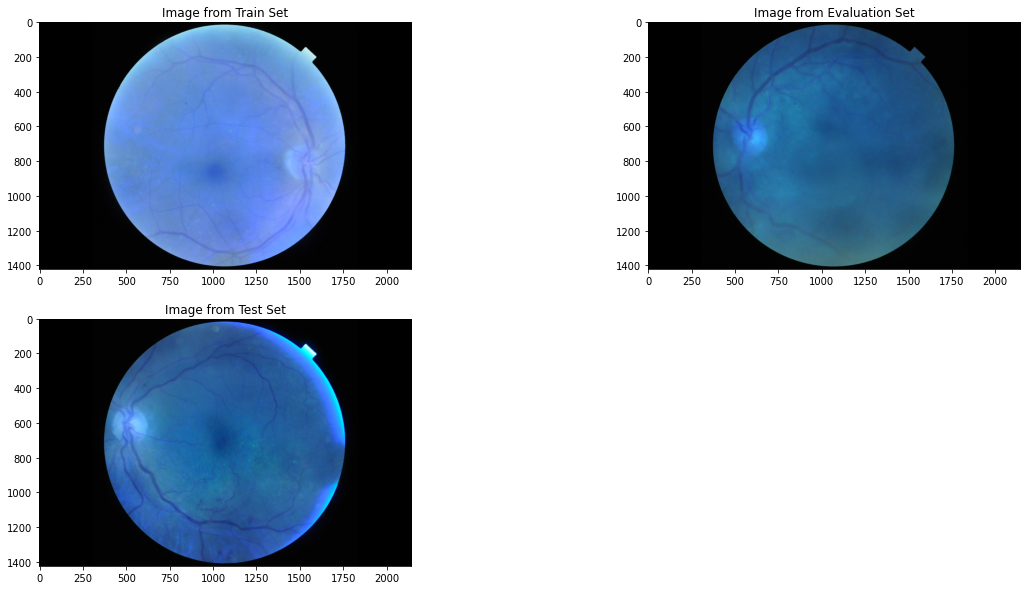

In [8]:
img1 = cv2.imread(f'/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training/100.png')
img2 = cv2.imread(f'/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation/100.png')
img3 = cv2.imread(f'/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/100.png')
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(img1)
plt.title("Image from Train Set")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Image from Evaluation Set")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Image from Test Set")

In [9]:
height, width = img2.shape[:2]
print(height)
print(width)

1424
2144


In [10]:
img1 = cv2.resize(img1, (256, 256))
img2 = cv2.resize(img2, (256, 256))
img3 = cv2.resize(img3, (256, 256))
height, width = img1.shape[:2]
print(height)
print(width)

256
256


Text(0.5, 1.0, 'Image from Test Set')

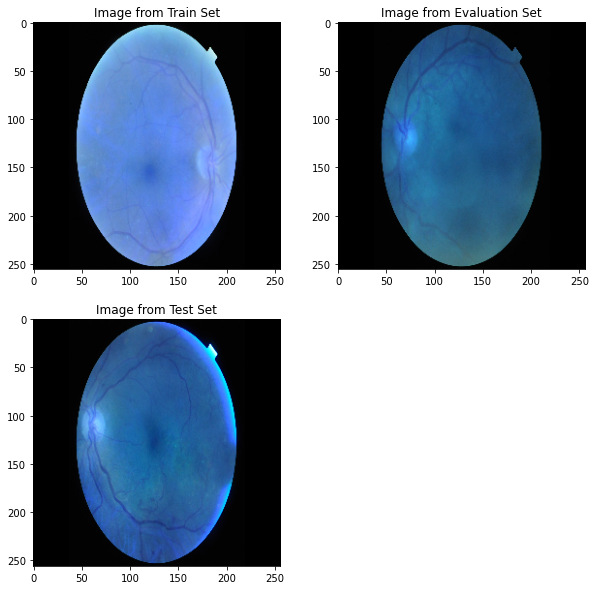

In [11]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(img1)
plt.title("Image from Train Set")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Image from Evaluation Set")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Image from Test Set")

In [12]:
z = dftrain["Disease_Risk"].value_counts()
trainStats = pd.DataFrame({"name":[z.name],"0":[z[0]],"1":[z[1]]})
for x in dftrain.columns[2:]:
    val = dftrain[x].value_counts()
    if(val.size==2):
        temp = pd.DataFrame({"name": [val.name], "0": [val[0]], "1": [val[1]]})
        trainStats = trainStats.append(temp,ignore_index=True)
    if(val.size==1):
        if(dftrain[x][0]==0):
            temp = pd.DataFrame(
                {"name": [val.name], "0": [val[0]], "1": [0]})
            trainStats = trainStats.append(temp,ignore_index=True)
        else:
            temp = pd.DataFrame(
                {"name": [val.name], "0": [0], "1": [val[1]]})
            trainStats = trainStats.append(temp,ignore_index=True)
trainStats

,name,0,1
0,Disease_Risk,401,1519
1,DR,1544,376
2,ARMD,1820,100
3,MH,1603,317
4,DN,1782,138
5,MYA,1819,101
6,BRVO,1847,73
7,TSLN,1734,186
8,ERM,1906,14
9,LS,1873,47


In [13]:
z = dfeval["MH"].value_counts(sort=True)
z[0]

538

(raylet) [2022-12-21 07:58:50,780 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71048212480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 07:59:00,790 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71048212480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 07:59:10,800 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71048212480; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 07:59:20,810 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71048212480; capacity: 4327869423616. Object creation will fail if spilling i

In [14]:
z = dfeval["Disease_Risk"].value_counts()
evalStats = pd.DataFrame({"name": [z.name], "0": [z[0]], "1": [z[1]]})
for x in dfeval.columns[2:]:
    val = dfeval[x].value_counts()
    if(val.size == 2):
        temp = pd.DataFrame({"name": [val.name], "0": [val[0]], "1": [val[1]]})
        evalStats = evalStats.append(temp, ignore_index=True)
    if(val.size == 1):
        if(dfeval[x][0] == 0):
            temp = pd.DataFrame(
                {"name": [val.name], "0": [val[0]], "1": [0]})
            evalStats = evalStats.append(temp, ignore_index=True)
        else:
            temp = pd.DataFrame(
            {"name": [val.name], "0": [0], "1": [val[1]]})
            evalStats = evalStats.append(temp, ignore_index=True)
evalStats

,name,0,1
0,Disease_Risk,134,506
1,DR,508,132
2,ARMD,602,38
3,MH,538,102
4,DN,594,46
5,MYA,606,34
6,BRVO,617,23
7,TSLN,575,65
8,ERM,633,7
9,LS,623,17


(raylet) [2022-12-21 08:16:21,880 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047487488; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:16:31,890 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047467008; capacity: 4327869423616. Object creation will fail if spilling is required.


In [15]:
z = dftest["Disease_Risk"].value_counts()
testStats = pd.DataFrame({"name": [z.name], "0": [z[0]], "1": [z[1]]})
for x in dftest.columns[2:]:
    val = dftest[x].value_counts()
    if(val.size == 2):
        temp = pd.DataFrame({"name": [val.name], "0": [val[0]], "1": [val[1]]})
        testStats = testStats.append(temp, ignore_index=True)
    if(val.size == 1):
        if(dftest[x][0] == 0):
            temp = pd.DataFrame(
                {"name": [val.name], "0": [val[0]], "1": [0]})
            testStats = testStats.append(temp, ignore_index=True)
        else:
            temp = pd.DataFrame(
                {"name": [val.name], "0": [0], "1": [val[1]]})
            testStats = testStats.append(temp, ignore_index=True)
testStats

,name,0,1
0,Disease_Risk,134,506
1,DR,516,124
2,ARMD,609,31
3,MH,536,104
4,DN,594,46
5,MYA,608,32
6,BRVO,617,23
7,TSLN,587,53
8,ERM,635,5
9,LS,625,15


(raylet) [2022-12-21 08:16:41,900 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047462912; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:16:51,911 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047454720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:17:01,921 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047454720; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:17:11,933 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047454720; capacity: 4327869423616. Object creation will fail if spilling i

Text(0.5, 1.0, 'Image from Test Set')

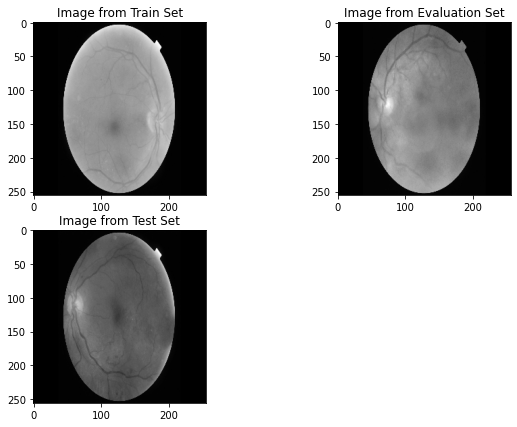

(raylet) [2022-12-21 08:19:52,097 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047331840; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:20:02,109 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047331840; capacity: 4327869423616. Object creation will fail if spilling is required.


In [16]:
grayscale1 = rgb2gray(img1)
grayscale2 = rgb2gray(img2)
grayscale3 = rgb2gray(img3)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(grayscale1, cmap=plt.cm.gray)
plt.title("Image from Train Set")
fig.add_subplot(2, 2, 2)
plt.imshow(grayscale2, cmap=plt.cm.gray)
plt.title("Image from Evaluation Set")
fig.add_subplot(2, 2, 3)
plt.imshow(grayscale3, cmap=plt.cm.gray)
plt.title("Image from Test Set")

In [17]:
min = np.amin(grayscale1)
max = np.amax(grayscale1)
print(min)
print(max)

0.0
0.8948941176470588


(raylet) [2022-12-21 08:20:12,121 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047323648; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:20:22,134 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047323648; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:20:32,144 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047286784; capacity: 4327869423616. Object creation will fail if spilling is required.


Text(0.5, 1.0, 'All channels')

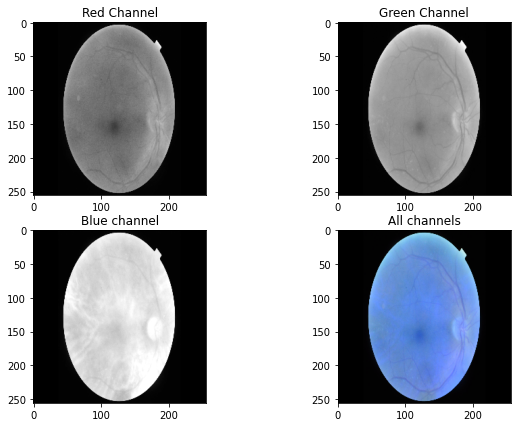

(raylet) [2022-12-21 08:20:42,155 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047286784; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:20:52,167 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047278592; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:21:02,178 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047270400; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:21:12,188 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71047270400; capacity: 4327869423616. Object creation will fail if spilling i

In [18]:
r = img1[:,:,0]
g = img1[...,1]
b = img1[...,2]

fig = plt.figure(figsize=(10,7))
fig.add_subplot(2, 2, 1)
plt.imshow(r, cmap=plt.cm.gray)
plt.title("Red Channel")
fig.add_subplot(2, 2, 2)
plt.imshow(g, cmap=plt.cm.gray)
plt.title("Green Channel")
fig.add_subplot(2, 2, 3)
plt.imshow(b, cmap=plt.cm.gray)
plt.title("Blue channel")
fig.add_subplot(2, 2, 4)
plt.imshow(img1, cmap=plt.cm.gray)
plt.title("All channels")

In [22]:
%%time
def model_preprocessImage(path,id):
    # print(path)
    img = cv2.imread(f'{path}/{id}.png')
    img = cv2.resize(img, (256, 256))
    # print(np.amax(img))
    if(img is None):
        print(id)
        return np.zeros((256,256))
    R, G, B = cv2.split(img)
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    img = cv2.merge((output1_R, output1_G, output1_B))
    img = rgb2gray(img)
    return img

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [24]:
model_dftrain = dftrain
model_dfeval = dfeval
model_dftest = dftest
model_dftrain['Image'] = model_dftrain.ID.apply(
    lambda id: model_preprocessImage(f'/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training',id))
model_dftest['Image'] = model_dftest.ID.apply(lambda id: model_preprocessImage(
    '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test', id))
model_dfeval['Image'] = model_dfeval.ID.apply(lambda id: model_preprocessImage(
    '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation', id))

(raylet) [2022-12-21 08:31:12,856 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046860800; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:31:22,865 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046856704; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:31:32,874 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046832128; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:31:42,883 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046832128; capacity: 4327869423616. Object creation will fail if spilling i

In [26]:
model_y = np.array(model_dftrain.drop(['ID', 'Image'], axis=1))
model_y.shape

(1920, 46)

(raylet) [2022-12-21 08:38:23,255 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046578176; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:38:33,266 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046553600; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:38:43,283 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046549504; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 08:38:53,294 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046545408; capacity: 4327869423616. Object creation will fail if spilling i

In [28]:
model_trainimages = []
for i in range(0,1920):
    model_trainimages.append(np.reshape(model_dftrain['Image'][i], [256, 256, 1]))
    if(i%500==0):
        print(i)
model_trainimages = np.array(model_trainimages)

0
500
1000
1500


(raylet) [2022-12-21 08:43:43,595 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046336512; capacity: 4327869423616. Object creation will fail if spilling is required.


In [29]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(256, 256, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(46, activation='sigmoid'))

2022-12-21 08:43:44.564002: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
(raylet) [2022-12-21 08:43:53,605 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046258688; capacity: 4327869423616. Object creation will fail if spilling is required.


In [30]:
print(model.output_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(None, 46)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 6

(raylet) [2022-12-21 08:44:03,616 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046254592; capacity: 4327869423616. Object creation will fail if spilling is required.


In [33]:
model.fit(model_trainimages, model_y, epochs=10, batch_size=1)

(raylet) [2022-12-21 08:44:33,645 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046230016; capacity: 4327869423616. Object creation will fail if spilling is required.
2022-12-21 08:44:33.842220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
 185/1920 [=>............................] - ETA: 1:23 - loss: 0.3221 - accuracy: 0.6054

(raylet) [2022-12-21 08:44:43,660 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046213632; capacity: 4327869423616. Object creation will fail if spilling is required.


 401/1920 [=====>........................] - ETA: 1:11 - loss: 0.2303 - accuracy: 0.7506

(raylet) [2022-12-21 08:44:53,669 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046209536; capacity: 4327869423616. Object creation will fail if spilling is required.


 611/1920 [========>.....................] - ETA: 1:02 - loss: 0.1979 - accuracy: 0.8232

(raylet) [2022-12-21 08:45:03,681 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046209536; capacity: 4327869423616. Object creation will fail if spilling is required.


 812/1920 [===========>..................] - ETA: 53s - loss: 0.1809 - accuracy: 0.8608

(raylet) [2022-12-21 08:45:13,690 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046209536; capacity: 4327869423616. Object creation will fail if spilling is required.


1023/1920 [==============>...............] - ETA: 43s - loss: 0.1675 - accuracy: 0.8847

(raylet) [2022-12-21 08:45:23,700 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046205440; capacity: 4327869423616. Object creation will fail if spilling is required.


1235/1920 [==================>...........] - ETA: 32s - loss: 0.1587 - accuracy: 0.9020

(raylet) [2022-12-21 08:45:33,711 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046164480; capacity: 4327869423616. Object creation will fail if spilling is required.


1422/1920 [=====================>........] - ETA: 24s - loss: 0.1523 - accuracy: 0.9142

(raylet) [2022-12-21 08:45:43,723 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046160384; capacity: 4327869423616. Object creation will fail if spilling is required.


1632/1920 [========================>.....] - ETA: 13s - loss: 0.1468 - accuracy: 0.9246

(raylet) [2022-12-21 08:45:53,738 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046160384; capacity: 4327869423616. Object creation will fail if spilling is required.


1840/1920 [===========================>..] - ETA: 3s - loss: 0.1424 - accuracy: 0.9332

(raylet) [2022-12-21 08:46:03,749 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046156288; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 94s 48ms/step - loss: 0.1412 - accuracy: 0.9359
Epoch 2/10
 132/1920 [=>............................] - ETA: 1:23 - loss: 0.1110 - accuracy: 1.0000

(raylet) [2022-12-21 08:46:13,759 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046148096; capacity: 4327869423616. Object creation will fail if spilling is required.


 344/1920 [====>.........................] - ETA: 1:13 - loss: 0.1092 - accuracy: 1.0000

(raylet) [2022-12-21 08:46:23,769 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046148096; capacity: 4327869423616. Object creation will fail if spilling is required.


 558/1920 [=======>......................] - ETA: 1:03 - loss: 0.1085 - accuracy: 1.0000

(raylet) [2022-12-21 08:46:33,782 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046131712; capacity: 4327869423616. Object creation will fail if spilling is required.


 759/1920 [==========>...................] - ETA: 55s - loss: 0.1086 - accuracy: 1.0000

(raylet) [2022-12-21 08:46:43,792 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046127616; capacity: 4327869423616. Object creation will fail if spilling is required.


 933/1920 [=============>................] - ETA: 48s - loss: 0.1067 - accuracy: 1.0000

(raylet) [2022-12-21 08:46:53,808 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046123520; capacity: 4327869423616. Object creation will fail if spilling is required.


1144/1920 [================>.............] - ETA: 38s - loss: 0.1066 - accuracy: 1.0000

(raylet) [2022-12-21 08:47:03,821 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046119424; capacity: 4327869423616. Object creation will fail if spilling is required.


1357/1920 [====================>.........] - ETA: 27s - loss: 0.1060 - accuracy: 1.0000

(raylet) [2022-12-21 08:47:13,830 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046119424; capacity: 4327869423616. Object creation will fail if spilling is required.


1563/1920 [=======================>......] - ETA: 17s - loss: 0.1049 - accuracy: 1.0000

(raylet) [2022-12-21 08:47:23,840 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046115328; capacity: 4327869423616. Object creation will fail if spilling is required.


1775/1920 [==========================>...] - ETA: 7s - loss: 0.1049 - accuracy: 1.0000

(raylet) [2022-12-21 08:47:33,851 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046094848; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 93s 49ms/step - loss: 0.1048 - accuracy: 1.0000
Epoch 3/10
  68/1920 [>.............................] - ETA: 1:26 - loss: 0.1086 - accuracy: 1.0000

(raylet) [2022-12-21 08:47:43,868 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046094848; capacity: 4327869423616. Object creation will fail if spilling is required.


 272/1920 [===>..........................] - ETA: 1:19 - loss: 0.1056 - accuracy: 1.0000

(raylet) [2022-12-21 08:47:53,880 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046094848; capacity: 4327869423616. Object creation will fail if spilling is required.


 484/1920 [======>.......................] - ETA: 1:08 - loss: 0.1046 - accuracy: 1.0000

(raylet) [2022-12-21 08:48:03,889 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046090752; capacity: 4327869423616. Object creation will fail if spilling is required.


 693/1920 [=========>....................] - ETA: 58s - loss: 0.1018 - accuracy: 1.0000

(raylet) [2022-12-21 08:48:13,902 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046082560; capacity: 4327869423616. Object creation will fail if spilling is required.


 896/1920 [=============>................] - ETA: 49s - loss: 0.1018 - accuracy: 1.0000

(raylet) [2022-12-21 08:48:23,915 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046082560; capacity: 4327869423616. Object creation will fail if spilling is required.


1102/1920 [================>.............] - ETA: 39s - loss: 0.1008 - accuracy: 1.0000

(raylet) [2022-12-21 08:48:33,930 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046045696; capacity: 4327869423616. Object creation will fail if spilling is required.


1311/1920 [===================>..........] - ETA: 29s - loss: 0.1006 - accuracy: 1.0000

(raylet) [2022-12-21 08:48:43,941 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046041600; capacity: 4327869423616. Object creation will fail if spilling is required.


1518/1920 [======================>.......] - ETA: 19s - loss: 0.0998 - accuracy: 1.0000

(raylet) [2022-12-21 08:48:53,953 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046037504; capacity: 4327869423616. Object creation will fail if spilling is required.


1726/1920 [=========================>....] - ETA: 9s - loss: 0.0999 - accuracy: 1.0000

(raylet) [2022-12-21 08:49:03,963 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046033408; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 92s 48ms/step - loss: 0.0996 - accuracy: 1.0000
Epoch 4/10
  18/1920 [..............................] - ETA: 1:25 - loss: 0.0881 - accuracy: 1.0000

(raylet) [2022-12-21 08:49:13,972 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046033408; capacity: 4327869423616. Object creation will fail if spilling is required.


 231/1920 [==>...........................] - ETA: 1:19 - loss: 0.0960 - accuracy: 1.0000

(raylet) [2022-12-21 08:49:23,996 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046025216; capacity: 4327869423616. Object creation will fail if spilling is required.


 442/1920 [=====>........................] - ETA: 1:09 - loss: 0.0991 - accuracy: 1.0000

(raylet) [2022-12-21 08:49:34,008 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046000640; capacity: 4327869423616. Object creation will fail if spilling is required.


 655/1920 [=========>....................] - ETA: 59s - loss: 0.1018 - accuracy: 1.0000

(raylet) [2022-12-21 08:49:44,018 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046000640; capacity: 4327869423616. Object creation will fail if spilling is required.


 862/1920 [============>.................] - ETA: 50s - loss: 0.1000 - accuracy: 0.9988

(raylet) [2022-12-21 08:49:54,028 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71046000640; capacity: 4327869423616. Object creation will fail if spilling is required.


1070/1920 [===============>..............] - ETA: 40s - loss: 0.0999 - accuracy: 0.9981

(raylet) [2022-12-21 08:50:04,039 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045996544; capacity: 4327869423616. Object creation will fail if spilling is required.


1278/1920 [==================>...........] - ETA: 30s - loss: 0.1000 - accuracy: 0.9977

(raylet) [2022-12-21 08:50:14,051 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045992448; capacity: 4327869423616. Object creation will fail if spilling is required.


1488/1920 [======================>.......] - ETA: 20s - loss: 0.0996 - accuracy: 0.9980

(raylet) [2022-12-21 08:50:24,061 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045992448; capacity: 4327869423616. Object creation will fail if spilling is required.


1696/1920 [=========================>....] - ETA: 10s - loss: 0.0995 - accuracy: 0.9982

(raylet) [2022-12-21 08:50:34,073 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045971968; capacity: 4327869423616. Object creation will fail if spilling is required.


1903/1920 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9984

(raylet) [2022-12-21 08:50:44,084 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045967872; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 92s 48ms/step - loss: 0.0985 - accuracy: 0.9984
Epoch 5/10
 193/1920 [==>...........................] - ETA: 1:22 - loss: 0.0988 - accuracy: 1.0000

(raylet) [2022-12-21 08:50:54,093 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045963776; capacity: 4327869423616. Object creation will fail if spilling is required.


 398/1920 [=====>........................] - ETA: 1:13 - loss: 0.0982 - accuracy: 0.9975

(raylet) [2022-12-21 08:51:04,108 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045963776; capacity: 4327869423616. Object creation will fail if spilling is required.


 611/1920 [========>.....................] - ETA: 1:02 - loss: 0.0955 - accuracy: 0.9984

(raylet) [2022-12-21 08:51:14,118 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045963776; capacity: 4327869423616. Object creation will fail if spilling is required.


 823/1920 [===========>..................] - ETA: 52s - loss: 0.0969 - accuracy: 0.9988

(raylet) [2022-12-21 08:51:24,129 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045959680; capacity: 4327869423616. Object creation will fail if spilling is required.


1036/1920 [===============>..............] - ETA: 42s - loss: 0.0971 - accuracy: 0.9990

(raylet) [2022-12-21 08:51:34,145 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045931008; capacity: 4327869423616. Object creation will fail if spilling is required.


1249/1920 [==================>...........] - ETA: 31s - loss: 0.0968 - accuracy: 0.9992

(raylet) [2022-12-21 08:51:44,156 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045926912; capacity: 4327869423616. Object creation will fail if spilling is required.


1458/1920 [=====================>........] - ETA: 21s - loss: 0.0976 - accuracy: 0.9986

(raylet) [2022-12-21 08:51:54,168 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045926912; capacity: 4327869423616. Object creation will fail if spilling is required.


1664/1920 [=========================>....] - ETA: 12s - loss: 0.0975 - accuracy: 0.9988

(raylet) [2022-12-21 08:52:04,180 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045922816; capacity: 4327869423616. Object creation will fail if spilling is required.


1881/1920 [============================>.] - ETA: 1s - loss: 0.0974 - accuracy: 0.9989

(raylet) [2022-12-21 08:52:14,189 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045918720; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 91s 47ms/step - loss: 0.0974 - accuracy: 0.9990
Epoch 6/10
 174/1920 [=>............................] - ETA: 1:23 - loss: 0.0973 - accuracy: 0.9943

(raylet) [2022-12-21 08:52:24,201 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045918720; capacity: 4327869423616. Object creation will fail if spilling is required.


 385/1920 [=====>........................] - ETA: 1:12 - loss: 0.0960 - accuracy: 0.9948

(raylet) [2022-12-21 08:52:34,215 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045881856; capacity: 4327869423616. Object creation will fail if spilling is required.


 599/1920 [========>.....................] - ETA: 1:02 - loss: 0.0982 - accuracy: 0.9950

(raylet) [2022-12-21 08:52:44,227 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045877760; capacity: 4327869423616. Object creation will fail if spilling is required.


 809/1920 [===========>..................] - ETA: 52s - loss: 0.0987 - accuracy: 0.9963

(raylet) [2022-12-21 08:52:54,237 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045873664; capacity: 4327869423616. Object creation will fail if spilling is required.


1018/1920 [==============>...............] - ETA: 42s - loss: 0.0995 - accuracy: 0.9971

(raylet) [2022-12-21 08:53:04,246 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045873664; capacity: 4327869423616. Object creation will fail if spilling is required.


1232/1920 [==================>...........] - ETA: 32s - loss: 0.0985 - accuracy: 0.9968

(raylet) [2022-12-21 08:53:14,260 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045873664; capacity: 4327869423616. Object creation will fail if spilling is required.


1447/1920 [=====================>........] - ETA: 22s - loss: 0.0976 - accuracy: 0.9972

(raylet) [2022-12-21 08:53:24,271 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045869568; capacity: 4327869423616. Object creation will fail if spilling is required.


1656/1920 [========================>.....] - ETA: 12s - loss: 0.0973 - accuracy: 0.9976

(raylet) [2022-12-21 08:53:34,280 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045844992; capacity: 4327869423616. Object creation will fail if spilling is required.


1870/1920 [============================>.] - ETA: 2s - loss: 0.0976 - accuracy: 0.9979

(raylet) [2022-12-21 08:53:44,294 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045844992; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 91s 47ms/step - loss: 0.0976 - accuracy: 0.9979
Epoch 7/10
 161/1920 [=>............................] - ETA: 1:23 - loss: 0.0992 - accuracy: 1.0000

(raylet) [2022-12-21 08:53:54,306 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045844992; capacity: 4327869423616. Object creation will fail if spilling is required.


 372/1920 [====>.........................] - ETA: 1:13 - loss: 0.0974 - accuracy: 1.0000

(raylet) [2022-12-21 08:54:04,317 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045840896; capacity: 4327869423616. Object creation will fail if spilling is required.


 586/1920 [========>.....................] - ETA: 1:03 - loss: 0.0967 - accuracy: 1.0000

(raylet) [2022-12-21 08:54:14,328 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045836800; capacity: 4327869423616. Object creation will fail if spilling is required.


 797/1920 [===========>..................] - ETA: 53s - loss: 0.0966 - accuracy: 1.0000

(raylet) [2022-12-21 08:54:24,339 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045836800; capacity: 4327869423616. Object creation will fail if spilling is required.


 998/1920 [==============>...............] - ETA: 44s - loss: 0.0980 - accuracy: 1.0000

(raylet) [2022-12-21 08:54:34,351 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045812224; capacity: 4327869423616. Object creation will fail if spilling is required.


1208/1920 [=================>............] - ETA: 34s - loss: 0.0978 - accuracy: 1.0000

(raylet) [2022-12-21 08:54:44,363 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045808128; capacity: 4327869423616. Object creation will fail if spilling is required.


1421/1920 [=====================>........] - ETA: 23s - loss: 0.0978 - accuracy: 1.0000

(raylet) [2022-12-21 08:54:54,373 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045804032; capacity: 4327869423616. Object creation will fail if spilling is required.


1630/1920 [========================>.....] - ETA: 13s - loss: 0.0975 - accuracy: 0.9994

(raylet) [2022-12-21 08:55:04,386 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045804032; capacity: 4327869423616. Object creation will fail if spilling is required.


1839/1920 [===========================>..] - ETA: 3s - loss: 0.0973 - accuracy: 0.9995

(raylet) [2022-12-21 08:55:14,396 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045804032; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 92s 48ms/step - loss: 0.0974 - accuracy: 0.9995
Epoch 8/10
 133/1920 [=>............................] - ETA: 1:23 - loss: 0.0926 - accuracy: 0.9925

(raylet) [2022-12-21 08:55:24,407 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045799936; capacity: 4327869423616. Object creation will fail if spilling is required.


 348/1920 [====>.........................] - ETA: 1:13 - loss: 0.0946 - accuracy: 0.9971

(raylet) [2022-12-21 08:55:34,418 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045754880; capacity: 4327869423616. Object creation will fail if spilling is required.


 553/1920 [=======>......................] - ETA: 1:04 - loss: 0.0953 - accuracy: 0.9964

(raylet) [2022-12-21 08:55:44,433 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045754880; capacity: 4327869423616. Object creation will fail if spilling is required.


 763/1920 [==========>...................] - ETA: 54s - loss: 0.0968 - accuracy: 0.9974

(raylet) [2022-12-21 08:55:54,443 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045754880; capacity: 4327869423616. Object creation will fail if spilling is required.


 976/1920 [==============>...............] - ETA: 44s - loss: 0.0967 - accuracy: 0.9980

(raylet) [2022-12-21 08:56:04,455 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045750784; capacity: 4327869423616. Object creation will fail if spilling is required.


1184/1920 [=================>............] - ETA: 34s - loss: 0.0964 - accuracy: 0.9983

(raylet) [2022-12-21 08:56:14,466 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045746688; capacity: 4327869423616. Object creation will fail if spilling is required.


1397/1920 [====================>.........] - ETA: 24s - loss: 0.0969 - accuracy: 0.9986

(raylet) [2022-12-21 08:56:24,476 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045746688; capacity: 4327869423616. Object creation will fail if spilling is required.


1610/1920 [========================>.....] - ETA: 14s - loss: 0.0966 - accuracy: 0.9988

(raylet) [2022-12-21 08:56:34,487 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045726208; capacity: 4327869423616. Object creation will fail if spilling is required.


1815/1920 [===========================>..] - ETA: 4s - loss: 0.0964 - accuracy: 0.9989

(raylet) [2022-12-21 08:56:44,499 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045722112; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 91s 48ms/step - loss: 0.0969 - accuracy: 0.9990
Epoch 9/10
 106/1920 [>.............................] - ETA: 1:26 - loss: 0.0945 - accuracy: 1.0000

(raylet) [2022-12-21 08:56:54,509 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045718016; capacity: 4327869423616. Object creation will fail if spilling is required.


 313/1920 [===>..........................] - ETA: 1:16 - loss: 0.0931 - accuracy: 0.9936

(raylet) [2022-12-21 08:57:04,520 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045718016; capacity: 4327869423616. Object creation will fail if spilling is required.


 523/1920 [=======>......................] - ETA: 1:07 - loss: 0.0946 - accuracy: 0.9962

(raylet) [2022-12-21 08:57:14,531 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045718016; capacity: 4327869423616. Object creation will fail if spilling is required.


 737/1920 [==========>...................] - ETA: 56s - loss: 0.0962 - accuracy: 0.9973

(raylet) [2022-12-21 08:57:24,543 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045709824; capacity: 4327869423616. Object creation will fail if spilling is required.


 949/1920 [=============>................] - ETA: 46s - loss: 0.0964 - accuracy: 0.9937

(raylet) [2022-12-21 08:57:34,553 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045685248; capacity: 4327869423616. Object creation will fail if spilling is required.


1160/1920 [=================>............] - ETA: 36s - loss: 0.0956 - accuracy: 0.9940

(raylet) [2022-12-21 08:57:44,565 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045685248; capacity: 4327869423616. Object creation will fail if spilling is required.


1369/1920 [====================>.........] - ETA: 26s - loss: 0.0952 - accuracy: 0.9949

(raylet) [2022-12-21 08:57:54,577 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045685248; capacity: 4327869423616. Object creation will fail if spilling is required.


1580/1920 [=======================>......] - ETA: 16s - loss: 0.0959 - accuracy: 0.9949

(raylet) [2022-12-21 08:58:04,587 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045681152; capacity: 4327869423616. Object creation will fail if spilling is required.


1789/1920 [==========================>...] - ETA: 6s - loss: 0.0962 - accuracy: 0.9955

(raylet) [2022-12-21 08:58:14,600 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045677056; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 91s 48ms/step - loss: 0.0961 - accuracy: 0.9953
Epoch 10/10
  81/1920 [>.............................] - ETA: 1:25 - loss: 0.1022 - accuracy: 1.0000

(raylet) [2022-12-21 08:58:24,609 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045677056; capacity: 4327869423616. Object creation will fail if spilling is required.


 286/1920 [===>..........................] - ETA: 1:18 - loss: 0.0981 - accuracy: 0.9860

(raylet) [2022-12-21 08:58:34,618 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045636096; capacity: 4327869423616. Object creation will fail if spilling is required.


 496/1920 [======>.......................] - ETA: 1:08 - loss: 0.0992 - accuracy: 0.9879

(raylet) [2022-12-21 08:58:44,630 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045632000; capacity: 4327869423616. Object creation will fail if spilling is required.


 706/1920 [==========>...................] - ETA: 58s - loss: 0.0980 - accuracy: 0.9915

(raylet) [2022-12-21 08:58:54,639 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045627904; capacity: 4327869423616. Object creation will fail if spilling is required.


 914/1920 [=============>................] - ETA: 48s - loss: 0.0980 - accuracy: 0.9934

(raylet) [2022-12-21 08:59:04,651 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045627904; capacity: 4327869423616. Object creation will fail if spilling is required.


1119/1920 [================>.............] - ETA: 38s - loss: 0.0965 - accuracy: 0.9946

(raylet) [2022-12-21 08:59:14,664 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045627904; capacity: 4327869423616. Object creation will fail if spilling is required.


1333/1920 [===================>..........] - ETA: 28s - loss: 0.0961 - accuracy: 0.9955

(raylet) [2022-12-21 08:59:24,677 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045623808; capacity: 4327869423616. Object creation will fail if spilling is required.


1547/1920 [=======================>......] - ETA: 17s - loss: 0.0956 - accuracy: 0.9955

(raylet) [2022-12-21 08:59:34,687 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045603328; capacity: 4327869423616. Object creation will fail if spilling is required.


1758/1920 [==========================>...] - ETA: 7s - loss: 0.0956 - accuracy: 0.9954

(raylet) [2022-12-21 08:59:44,700 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045603328; capacity: 4327869423616. Object creation will fail if spilling is required.


1920/1920 [==============================] - 92s 48ms/step - loss: 0.0961 - accuracy: 0.9958


(raylet) [2022-12-21 08:59:54,712 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045599232; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:00:04,723 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045595136; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:00:14,733 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045586944; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:00:24,743 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71045586944; capacity: 4327869423616. Object creation will fail if spilling i

In [34]:
model_evalimages = []
for i in range(0, 640):
    model_evalimages.append(np.reshape(model_dfeval['Image'][i], [256, 256, 1]))
    if(i % 500 == 0):
        print(i)
model_evalimages = np.array(model_evalimages)
model_yeval = np.array(model_dfeval.drop(['ID', 'Image'], axis=1))
model_yeval.shape

0
500


(640, 46)

(raylet) [2022-12-21 09:37:27,077 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044071424; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:37:37,088 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044046848; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:37:47,099 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044046848; capacity: 4327869423616. Object creation will fail if spilling is required.


In [35]:
model_testimages = []
for i in range(0, 640):
    model_testimages.append(np.reshape(model_dftest['Image'][i], [256, 256, 1]))
    if(i % 500 == 0):
        print(i)
model_testimages = np.array(model_testimages)
model_ytest = np.array(model_dftest.drop(['ID', 'Image'], axis=1))
model_ytest.shape

0
500


(640, 46)

(raylet) [2022-12-21 09:37:57,111 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044042752; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:38:07,123 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044042752; capacity: 4327869423616. Object creation will fail if spilling is required.


In [37]:
model.evaluate(model_evalimages,model_yeval,batch_size=1)

 82/640 [==>...........................] - ETA: 11s - loss: 0.1261 - accuracy: 1.0000

(raylet) [2022-12-21 09:38:17,134 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044030464; capacity: 4327869423616. Object creation will fail if spilling is required.


580/640 [==========================>...] - ETA: 1s - loss: 0.1007 - accuracy: 1.0000

(raylet) [2022-12-21 09:38:27,147 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044030464; capacity: 4327869423616. Object creation will fail if spilling is required.


640/640 [==============================] - 13s 20ms/step - loss: 0.0972 - accuracy: 1.0000


[0.09718113392591476, 1.0]

(raylet) [2022-12-21 09:38:37,157 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044005888; capacity: 4327869423616. Object creation will fail if spilling is required.


In [38]:
model.evaluate(model_testimages, model_yeval, batch_size=1)

127/640 [====>.........................] - ETA: 10s - loss: 0.1217 - accuracy: 1.0000

(raylet) [2022-12-21 09:38:47,168 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044005888; capacity: 4327869423616. Object creation will fail if spilling is required.


626/640 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 1.0000

(raylet) [2022-12-21 09:38:57,180 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044001792; capacity: 4327869423616. Object creation will fail if spilling is required.


640/640 [==============================] - 13s 20ms/step - loss: 0.0977 - accuracy: 1.0000


[0.09772112965583801, 1.0]

(raylet) [2022-12-21 09:39:07,191 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71044001792; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:39:17,202 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71043997696; capacity: 4327869423616. Object creation will fail if spilling is required.
(raylet) [2022-12-21 09:39:27,213 E 112 144] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-12-21_07-58-28_246558_27 is over 95% full, available space: 71043993600; capacity: 4327869423616. Object creation will fail if spilling is required.
